# Physics-Informed Neural Network for 1D Heat Equation

## Problem Setup
We solve: $\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

 - **Forward Problem**: Given $\alpha$, find $u(x,t)$
 - **Inverse Problem**: Given measurements of $u$, find $\alpha$

In [1]:
import torch
import numpy as np

import sys
sys.path.append('..')

from data.heat_data import HeatEquationData
from models.heat_pinn_strategy import StrategicPINN, WeakFormLoss
from training.trainer_strategy import StrategicPINNTrainer
from utils.plotter import plot_solution
from utils.test_functions import generate_compact_gaussians, plot_compact_gaussians

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Imports successful.")

Imports successful.


## Generate Data

### Base data

Data Generator initialized:
  Domain: x ∈ [0, 1.0], t ∈ [0, 1.0]
  True alpha: 0.01
  Collocation points: 10000
  Boundary points: 100
  Initial condition points: 200
  Measurements: 10 sensors × 10 times = 100 total
  Noise level: 1.0% (SNR ≈ 40 dB)

Generating complete dataset...

Measurements generated:
  Sensor locations: [0.09090909 0.18181818 0.27272727 0.36363636 0.45454545 0.54545455
 0.63636364 0.72727273 0.81818182 0.90909091]
  Time points: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
  Total measurements: 100
  Actual SNR: 40.3 dB

Dataset generation complete.


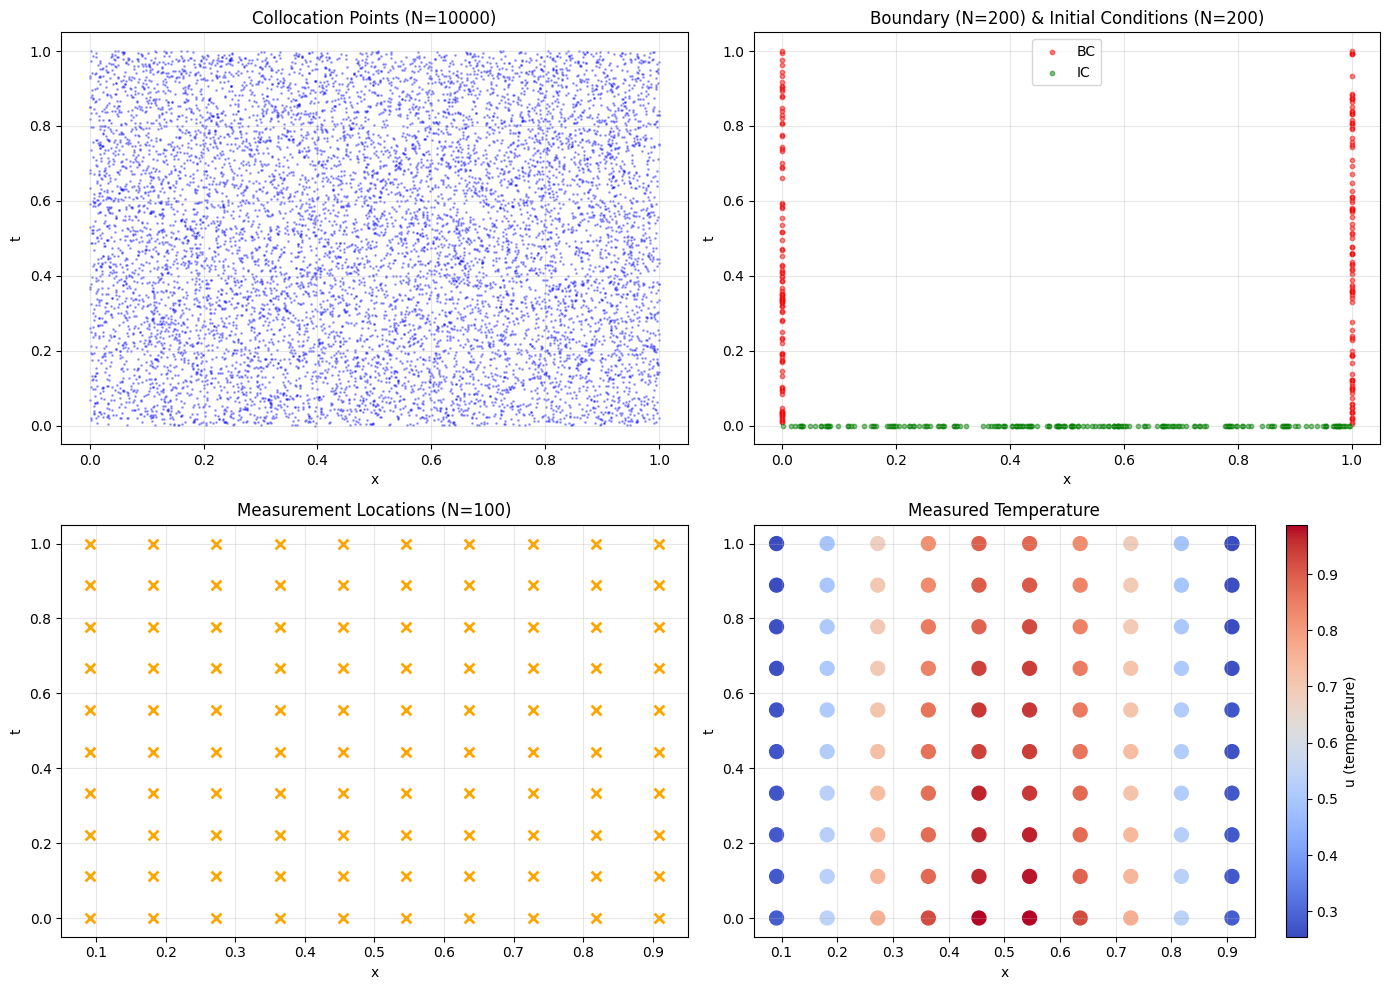

In [2]:
data_gen = HeatEquationData(
    L=1.0,                  # Domain length
    T=1.0,                  # Final time
    alpha=0.01,             # True thermal diffusivity
    N_f=10000,              # Number of collocation points
    N_bc = 100,             # BC points
    N_ic = 200,             # IC points
    N_sensors=10,           # Sensor locations
    N_time_measurements=10, # Time measurements
    noise_level=0.01,       # 1% noise (SNR ~ 40 dB)
    device='cpu'
)

# Generate base dataset
base_data = data_gen.generate_full_dataset()

# Visualize the data
data_gen.visualize_data(base_data)

### Test functions for weak form 

Test function generation complete.


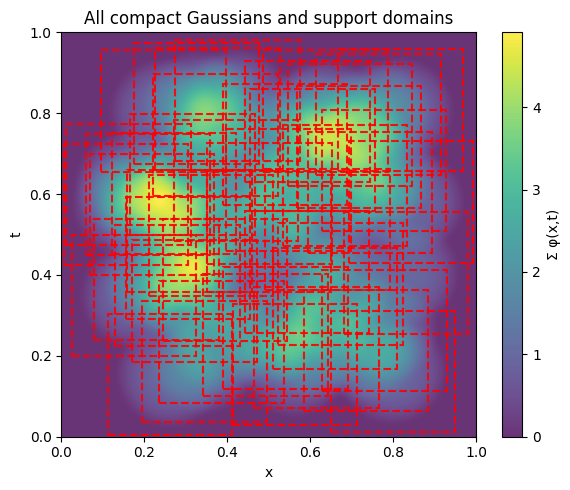

In [3]:
test_funcs, test_doms = generate_compact_gaussians(
    L=1.0,
    T=1.0,
    n_funcs=50, 
    support_radius=0.15,
    shrink=0.15,
    min_separation=0.05,
    smooth=False)

print("Test function generation complete.")

plot_compact_gaussians(test_funcs, test_doms)

### Collect strong- and weak-form data

In [4]:
strong_data = {
    'x_f': base_data['x_f'],
    't_f': base_data['t_f'],
    'x_bc': base_data['x_bc'],
    't_bc': base_data['t_bc'],
    'u_bc': base_data['u_bc'],
    'x_ic': base_data['x_ic'],
    't_ic': base_data['t_ic'],
    'u_ic': base_data['u_ic'],
    'x_m': base_data['x_m'],
    't_m': base_data['t_m'],
    'u_m': base_data['u_m']
}

In [5]:
weak_data = {
    'test_funcs': test_funcs,
    'test_doms': test_doms,
    'x_bc': base_data['x_bc'],
    't_bc': base_data['t_bc'],
    'u_bc': base_data['u_bc'],
    'x_ic': base_data['x_ic'],
    't_ic': base_data['t_ic'],
    'u_ic': base_data['u_ic'],
    'x_m': base_data['x_m'],
    't_m': base_data['t_m'],
    'u_m': base_data['u_m']
}

# Strong-form PINN

## Forward Problem

In [6]:
strong_model_forward = StrategicPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01, 
    inverse=False
)

Forward problem mode: alpha fixed to 0.01
StrategicPINN initialized with StrongFormLoss (default)


Trainer initialized:
  Loss strategy: StrongFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 4.255244e-01
  Residual: 2.943220e-04 (λ=1.00)
  Boundary: 1.297725e-02 (λ=1.00)
  Initial: 4.122528e-01 (λ=1.00)

Epoch 1000/5000 (111.0s)
  Adam learning rate: 1.00e-03
  Total: 1.081382e-04
  Residual: 1.230911e-05 (λ=2.25)
  Boundary: 2.718386e-05 (λ=0.76)
  Initial: 7.425269e-05 (λ=0.81)

Adam LR reduced: 1.00e-03 -> 5.00e-04

Epoch 2000/5000 (234.0s)
  Adam learning rate: 5.00e-04
  Total: 4.958095e-05
  Residual: 7.647085e-06 (λ=3.04)
  Boundary: 1.290967e-05 (λ=0.71)
  Initial: 2.160455e-05 (λ=0.80)

Switching to L-BFGS at Epoch 2173
   Reason: Plateau detected (var=0.099993, slope=0.000589)
   Loss before switch: 4.4722

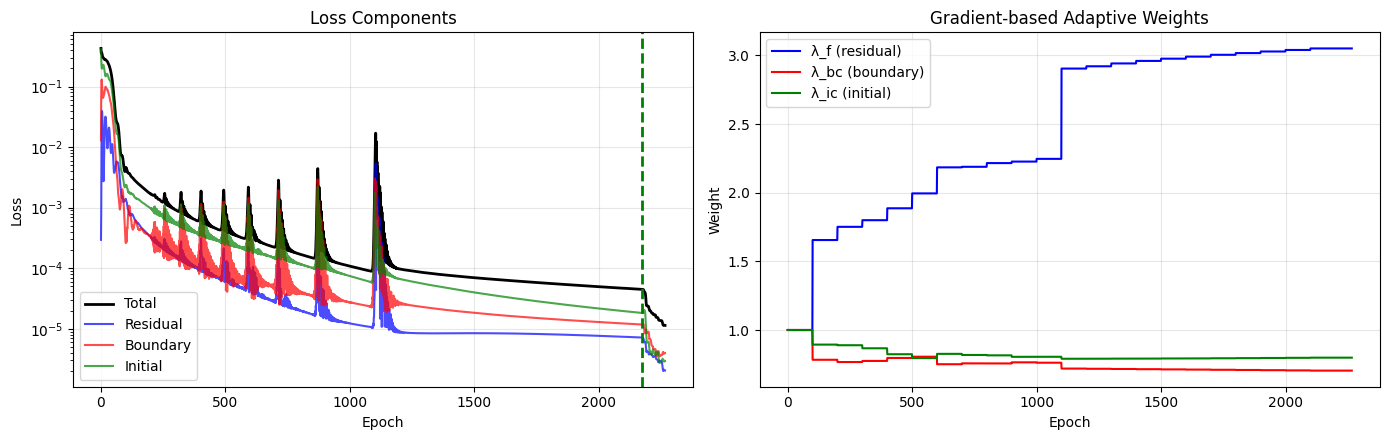


Training complete. Time: 263.9s


In [7]:
strong_trainer_forward = StrategicPINNTrainer(
    model=strong_model_forward,
    data=strong_data,
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

strong_trainer_forward.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

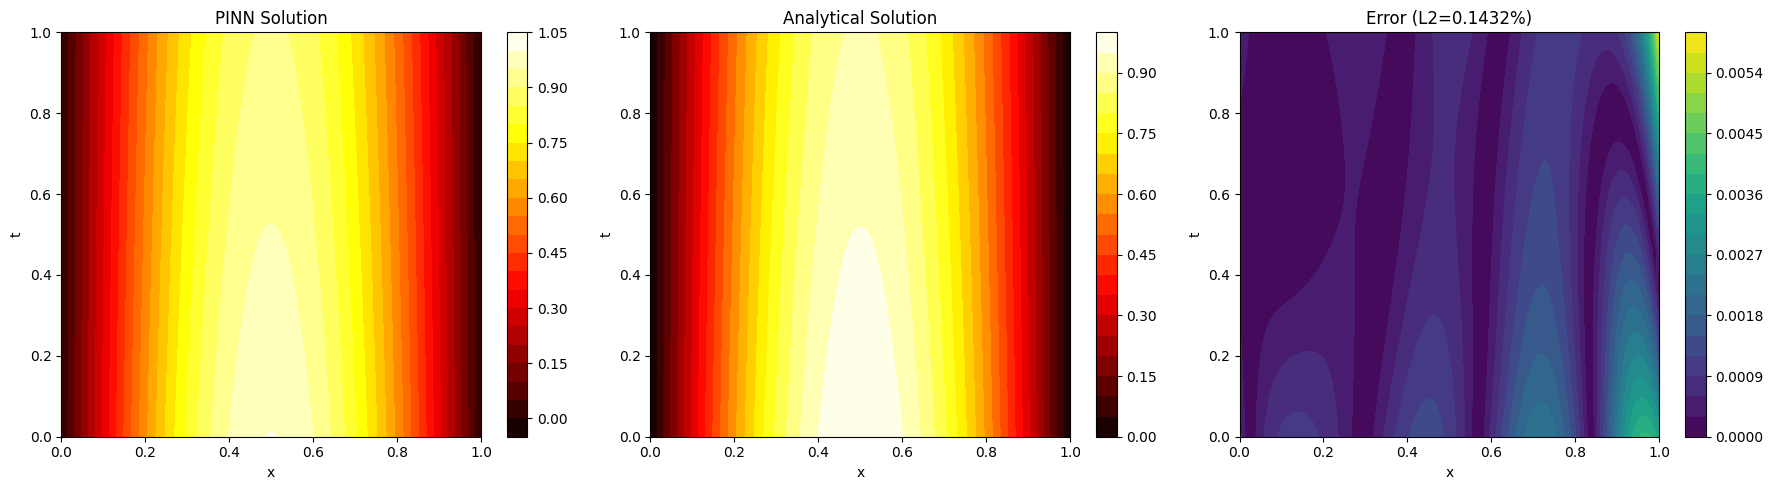

In [8]:
plot_solution(model=strong_model_forward, data=strong_data, alpha_true=0.01)

## Inverse Problem

In [9]:
strong_model_inverse = StrategicPINN(
    layers=[2, 50, 50, 50, 50, 1],
    inverse=True,
    alpha_init=0.02
)

Inverse problem mode: alpha initialized to 0.02
StrategicPINN initialized with StrongFormLoss (default)


Trainer initialized:
  Loss strategy: StrongFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total: 1.520335e+00
  Residual: 3.129298e-02 (λ=1.00)
  Boundary: 3.821262e-02 (λ=1.00)
  Initial: 6.636565e-01 (λ=1.00)
  Measurement: 7.871733e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)

Epoch 1000/5000 (106.5s)
  Adam learning rate: 1.00e-03
  Total: 9.080961e-04
  Residual: 6.231871e-05 (λ=4.35)
  Boundary: 2.323975e-04 (λ=0.52)
  Initial: 2.112950e-04 (λ=1.24)
  Measurement: 2.617919e-04 (λ=0.97)
  Alpha: 0.006982 (true: 0.01)

Epoch 2000/5000 (216.2s)
  Adam learning rate: 1.00e-03
  Total: 1.460912e-04
  Residual: 4.711787e-06 (λ=4.00)
  Boundary: 4.281982e-05 (λ=0.51)
  Initial: 3.302380e-05 (λ=1.22)
  Measurement: 6.417385e-0

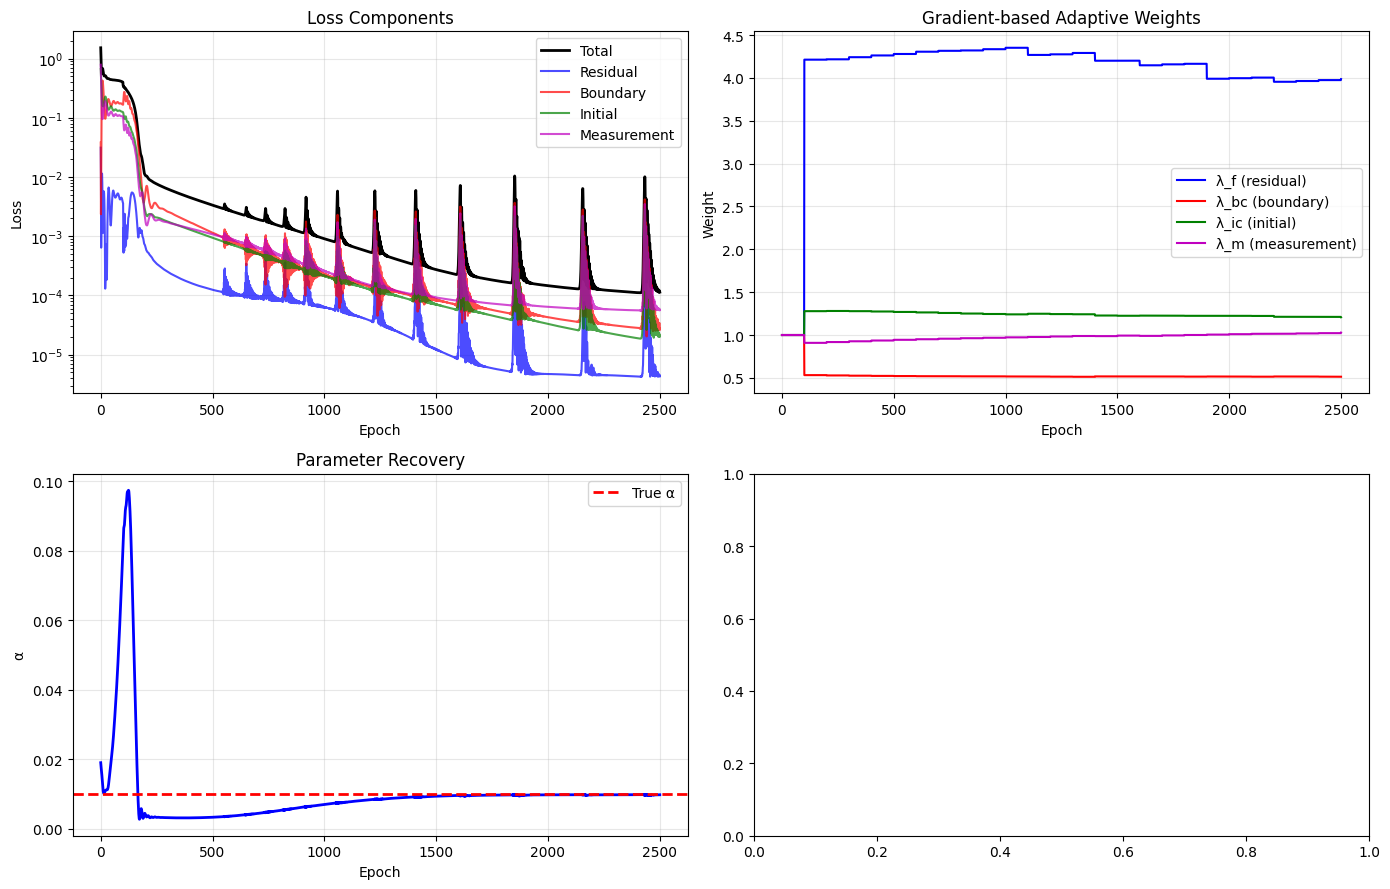


Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at Epoch 2682
   Reason: Plateau detected (var=0.098902, slope=0.000553)
   Loss before switch: 1.063175e-04

L-BFGS Step 1/100
  Internal iterations: 23
  Loss: 9.326267e-05
  Improvement: 12.28%

L-BFGS Step 2/100
  Internal iterations: 21
  Loss: 7.519880e-05
  Improvement: 29.27%

L-BFGS Step 3/100
  Internal iterations: 20
  Loss: 6.643313e-05
  Improvement: 37.51%

L-BFGS Step 4/100
  Internal iterations: 1
  Loss: 6.643313e-05
  Improvement: 37.51%

L-BFGS Step 5/100
  Internal iterations: 1
  Loss: 6.643313e-05
  Improvement: 37.51%

L-BFGS converged (loss change: 0.000000e+00)

Final training plot:


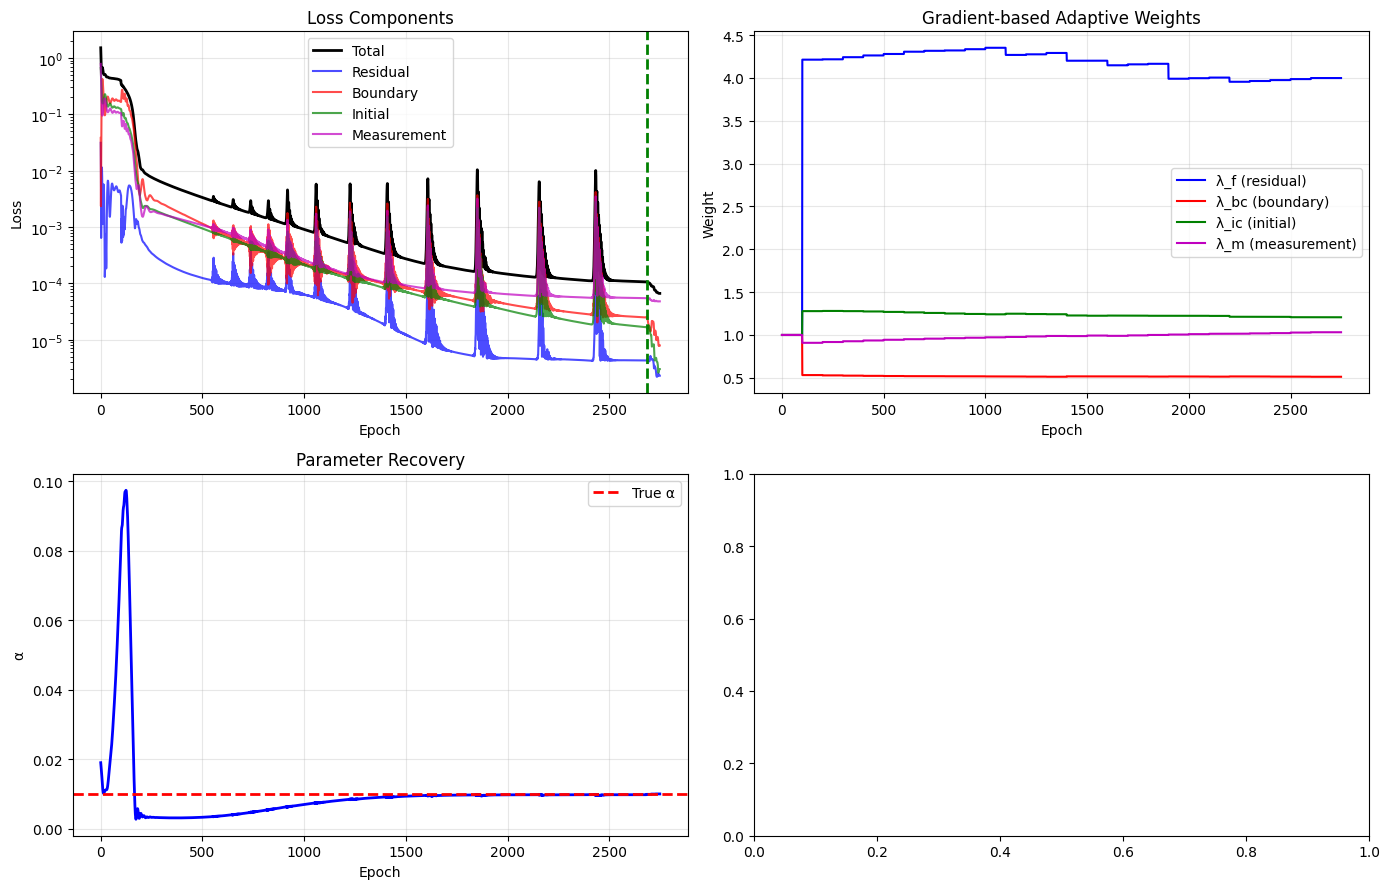


Training complete. Time: 302.3s


In [10]:
strong_trainer_inverse = StrategicPINNTrainer(
    model=strong_model_inverse,
    data=strong_data,
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

strong_trainer_inverse.train(
    epochs=5000,
    print_every=1000,
    plot_every=2500
)

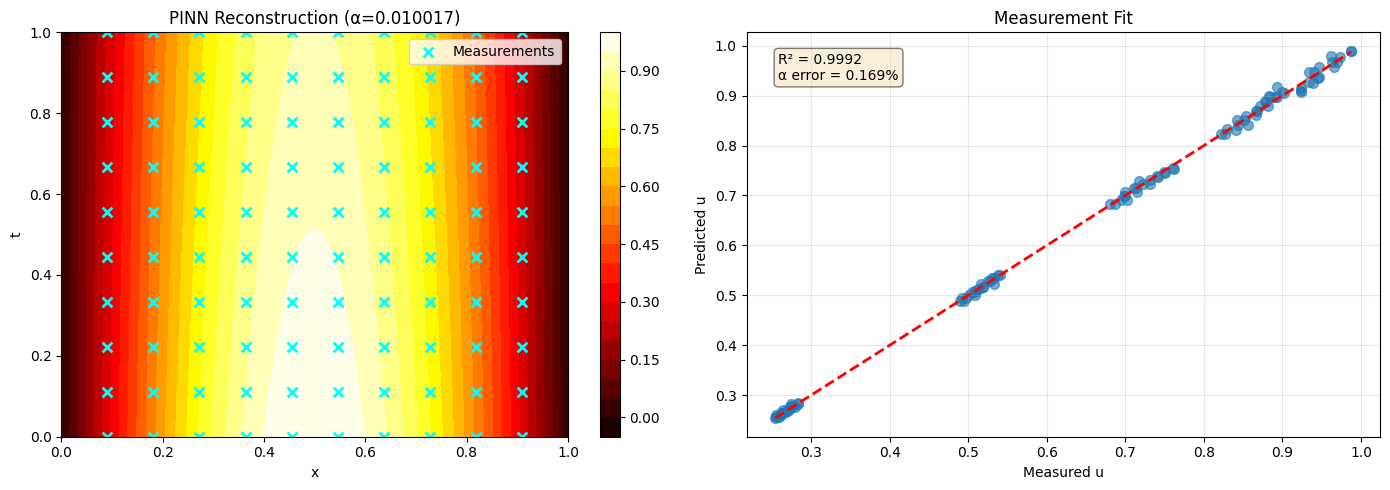

In [11]:
plot_solution(model=strong_model_inverse, data=strong_data, alpha_true=0.01)

# Weak-form PINN

## Forward Problem

In [12]:
weak_model_forward = StrategicPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01, 
    inverse=False
)

Forward problem mode: alpha fixed to 0.01
StrategicPINN initialized with StrongFormLoss (default)


### Simpson integration

Weak-form loss strategy:
  Method: simpson
  Points: 21
Loss strategy changed to WeakFormLoss
Trainer initialized:
  Loss strategy: WeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 8.395650e-01
  Residual: 1.213529e-05 (λ=1.00)
  Boundary: 4.115010e-02 (λ=1.00)
  Initial: 7.984028e-01 (λ=1.00)
  Non-zero weak residuals: 50

Epoch 1000/5000 (193.2s)
  Adam learning rate: 1.00e-03
  Total: 4.077957e-04
  Residual: 3.072686e-07 (λ=168.99)
  Boundary: 1.046910e-04 (λ=0.74)
  Initial: 4.563806e-04 (λ=0.61)
  Non-zero weak residuals: 50

Adam LR reduced: 1.00e-03 -> 5.00e-04

Epoch 2000/5000 (382.8s)
  Adam learning rate: 5.00e-04
  Total: 1.450570e-04
  Residual: 1.084828e-07 (λ=231.41)
  Boundary: 3.970137e-05 (λ=0.70)


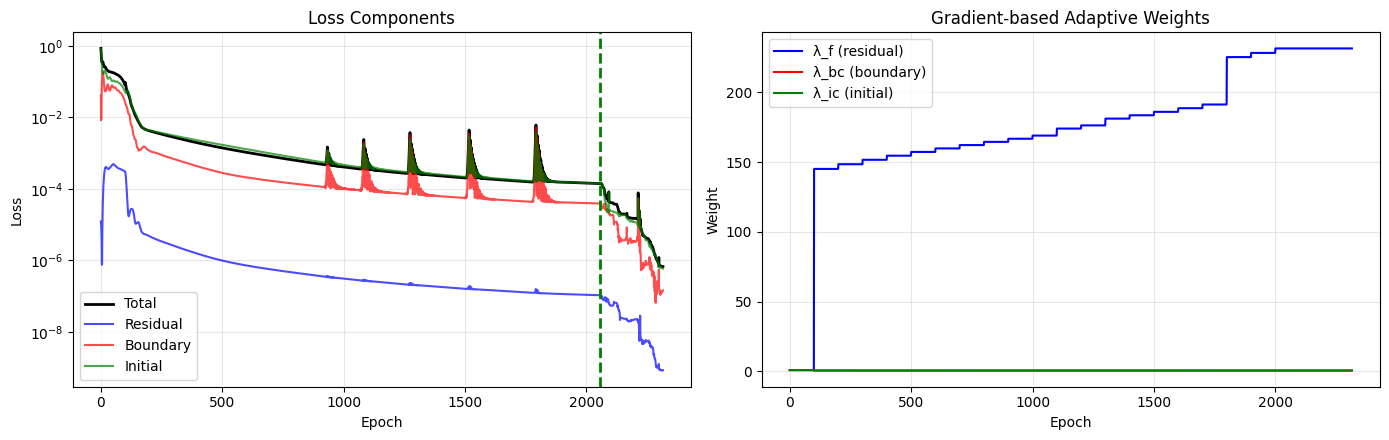


Training complete. Time: 447.0s


In [13]:
weak_model_forward.set_loss_strategy(
    WeakFormLoss(
        integration_method='simpson',
        n_integration_points=21
    )
)

trainer_weak = StrategicPINNTrainer(
    model=weak_model_forward, 
    data=weak_data,
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

trainer_weak.train(
    epochs=5000, 
    print_every=1000, 
    plot_every=2500)

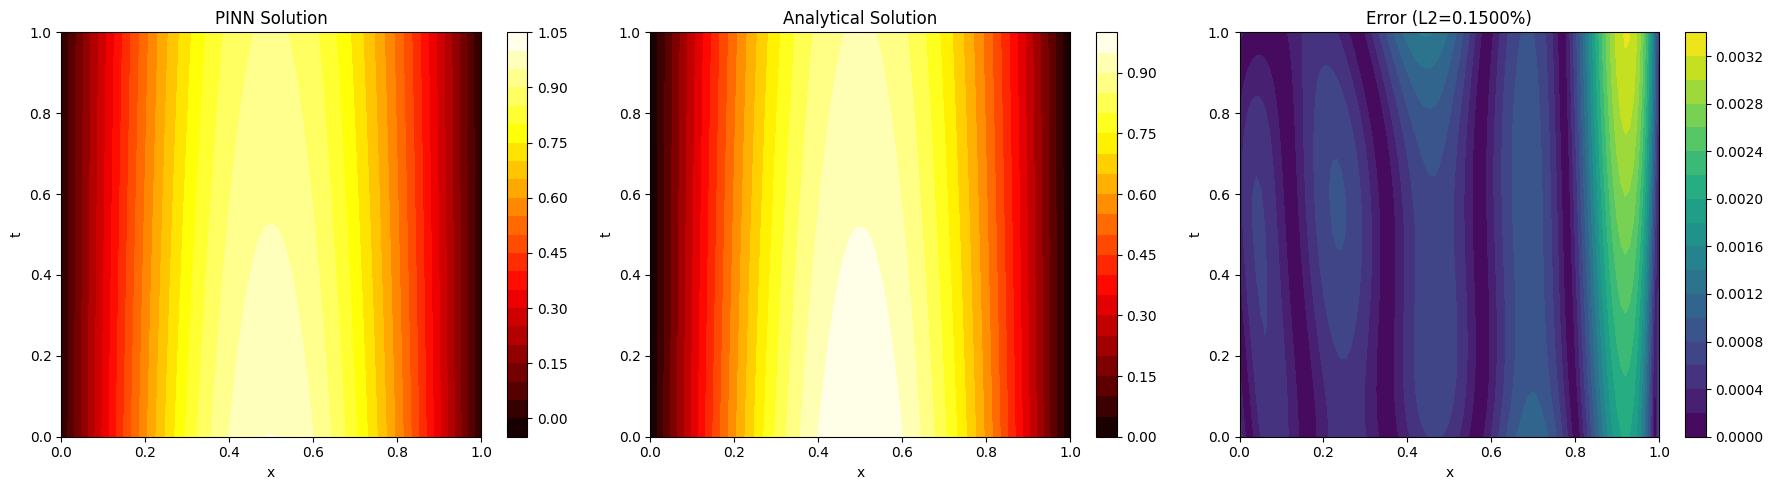

In [14]:
plot_solution(model=weak_model_forward, data=weak_data, alpha_true=0.01)

### Gauss-Legendre integration

In [15]:
weak_model_forward = StrategicPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01, 
    inverse=False
)

Forward problem mode: alpha fixed to 0.01
StrategicPINN initialized with StrongFormLoss (default)


Weak-form loss strategy:
  Method: gauss_legendre
  Points: 15
Loss strategy changed to WeakFormLoss
Trainer initialized:
  Loss strategy: WeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.1s)
  Adam learning rate: 1.00e-03
  Total: 1.332947e+00
  Residual: 1.058849e-06 (λ=1.00)
  Boundary: 2.043923e-01 (λ=1.00)
  Initial: 1.128554e+00 (λ=1.00)
  Non-zero weak residuals: 50

Epoch 1000/5000 (188.6s)
  Adam learning rate: 1.00e-03
  Total: 3.696029e-04
  Residual: 1.596057e-07 (λ=223.10)
  Boundary: 2.226731e-04 (λ=0.67)
  Initial: 2.777530e-04 (λ=0.67)
  Non-zero weak residuals: 50

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to L-BFGS at Epoch 1919
   Reason: Plateau detected (var=0.099362, slope=0.000581)
   Loss before switch: 8.776414e-05

L-BFGS Step

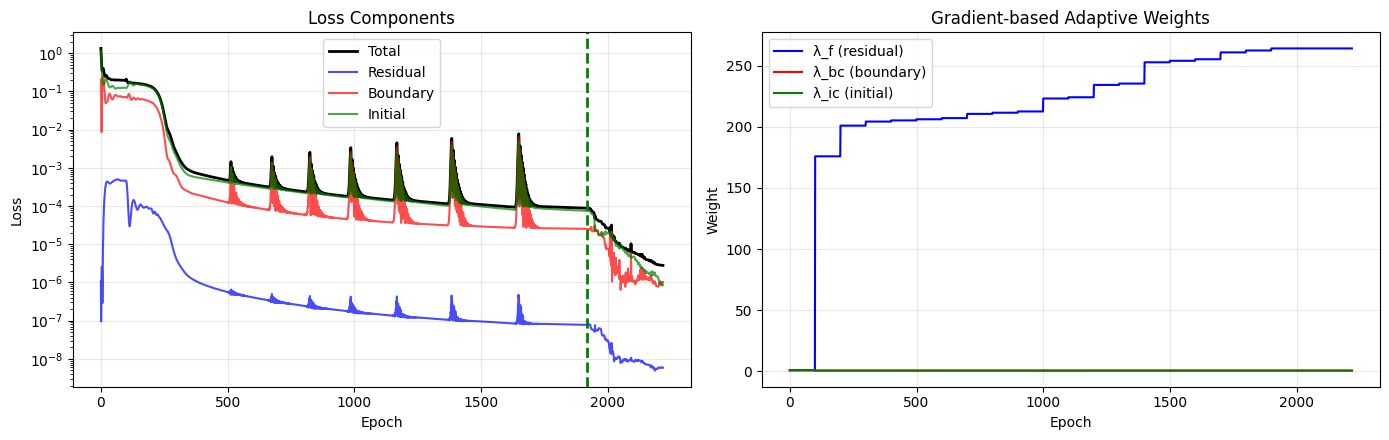


Training complete. Time: 381.0s


In [16]:
weak_model_forward.set_loss_strategy(
    WeakFormLoss(
        integration_method='gauss_legendre',
        n_integration_points=15
    )
)

trainer_weak = StrategicPINNTrainer(
    model=weak_model_forward, 
    data=weak_data,
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

trainer_weak.train(
    epochs=5000, 
    print_every=1000, 
    plot_every=2500)

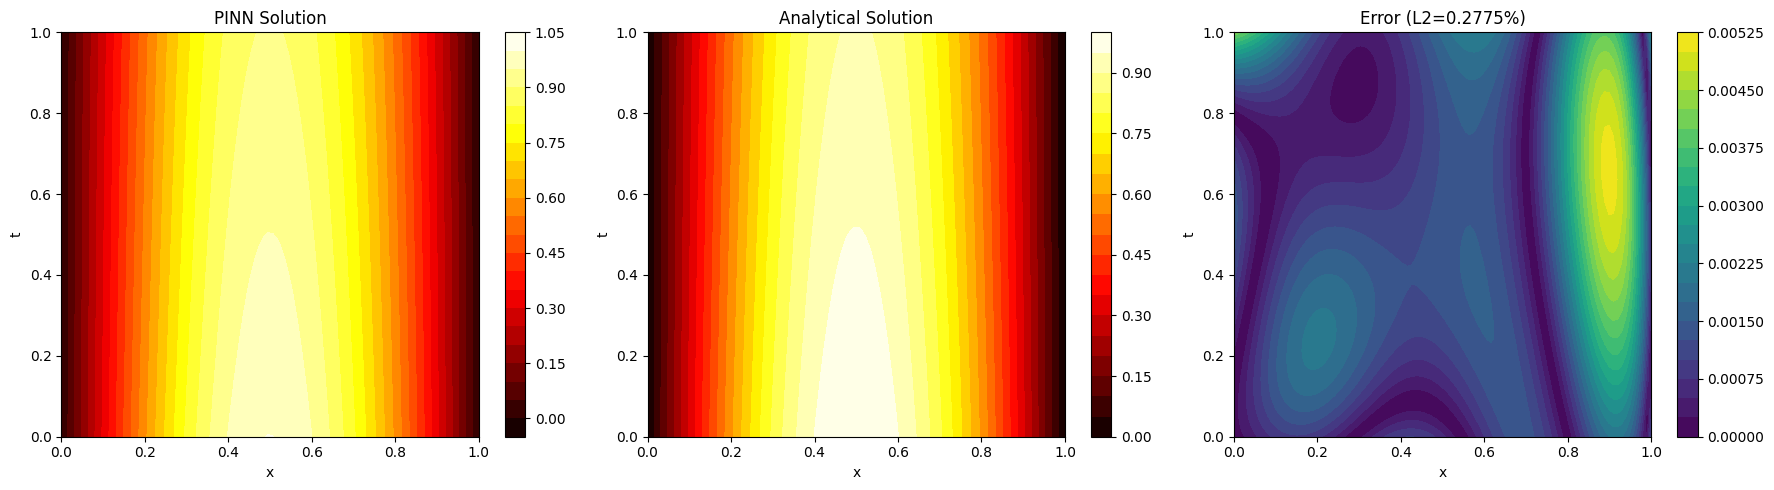

In [17]:
plot_solution(model=weak_model_forward, data=weak_data, alpha_true=0.01)

### Higher order G-L 

In [24]:
weak_model_forward = StrategicPINN(
    layers=[2, 50, 50, 50, 50, 1],
    alpha_true=0.01, 
    inverse=False
)

Forward problem mode: alpha fixed to 0.01
StrategicPINN initialized with StrongFormLoss (default)


Weak-form loss strategy:
  Method: gauss_legendre
  Points: 25
Loss strategy changed to WeakFormLoss
Trainer initialized:
  Loss strategy: WeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Forward

Starting training...

Epoch 0/5000 (0.3s)
  Adam learning rate: 1.00e-03
  Total: 5.117073e-01
  Residual: 6.162344e-05 (λ=1.00)
  Boundary: 3.735176e-02 (λ=1.00)
  Initial: 4.742939e-01 (λ=1.00)
  Non-zero weak residuals: 50

Epoch 1000/5000 (248.9s)
  Adam learning rate: 1.00e-03
  Total: 2.355662e-04
  Residual: 1.776880e-07 (λ=77.45)
  Boundary: 9.716329e-05 (λ=0.63)
  Initial: 2.246245e-04 (λ=0.72)
  Non-zero weak residuals: 50

Epoch 2000/5000 (489.9s)
  Adam learning rate: 1.00e-03
  Total: 1.484638e-05
  Residual: 2.350948e-08 (λ=92.78)
  Boundary: 1.227245e-05 (λ=0.61)
  Initial: 6.986662e-06 (λ=0.74)
 

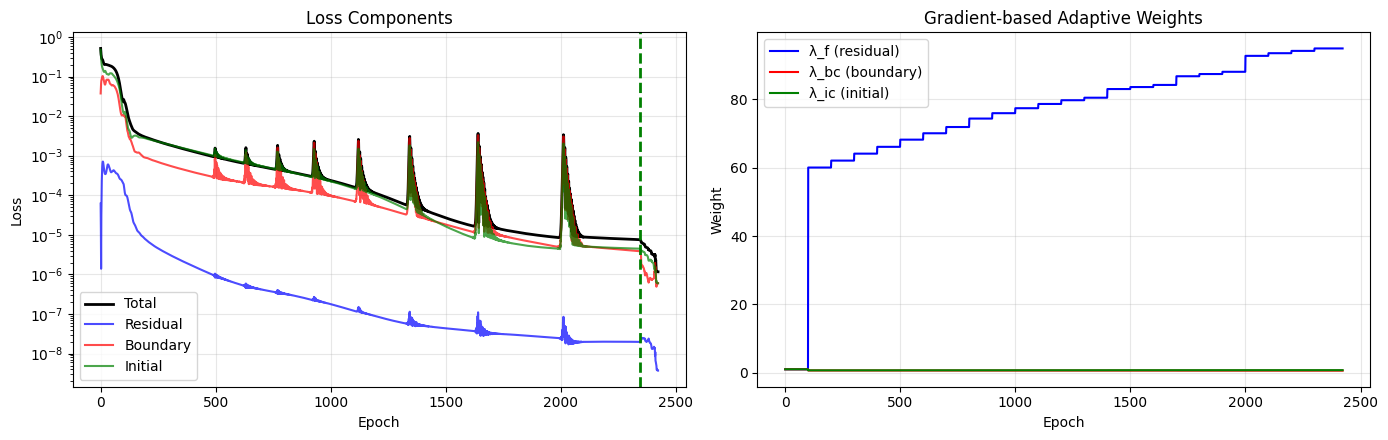


Training complete. Time: 597.7s


In [25]:
weak_model_forward.set_loss_strategy(
    WeakFormLoss(
        integration_method='gauss_legendre',
        n_integration_points=25
    )
)

trainer_weak = StrategicPINNTrainer(
    model=weak_model_forward, 
    data=weak_data,
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

trainer_weak.train(
    epochs=5000, 
    print_every=1000, 
    plot_every=2500)

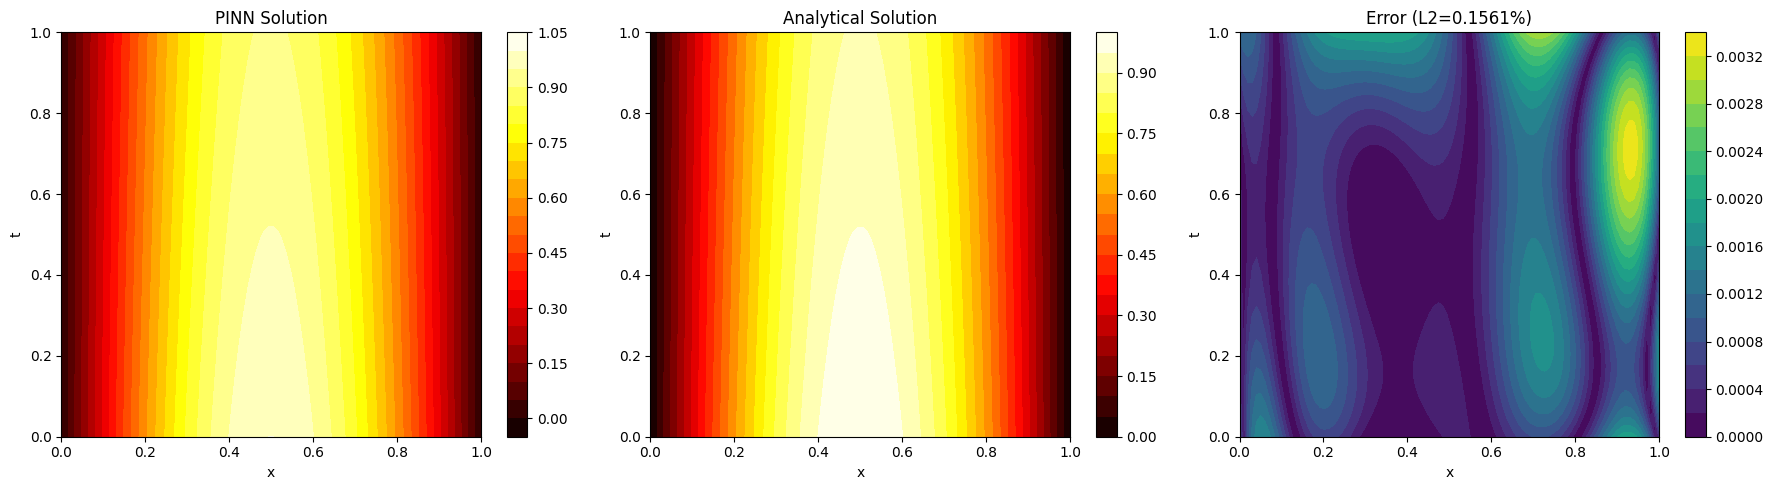

In [26]:
plot_solution(model=weak_model_forward, data=weak_data, alpha_true=0.01)

## Inverse Problem

In [18]:
weak_model_inverse = StrategicPINN(
    layers=[2, 50, 50, 50, 50, 1], 
    inverse=True,
    alpha_init=0.02,
)

Inverse problem mode: alpha initialized to 0.02
StrategicPINN initialized with StrongFormLoss (default)


### Simpson integration

Weak-form loss strategy:
  Method: simpson
  Points: 21
Loss strategy changed to WeakFormLoss
Trainer initialized:
  Loss strategy: WeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.3s)
  Adam learning rate: 1.00e-03
  Total: 8.886992e-01
  Residual: 8.029221e-05 (λ=1.00)
  Boundary: 2.705480e-02 (λ=1.00)
  Initial: 5.327349e-01 (λ=1.00)
  Measurement: 3.288291e-01 (λ=1.00)
  Alpha: 0.019000 (true: 0.01)
  Non-zero weak residuals: 50

Epoch 1000/5000 (188.4s)
  Adam learning rate: 1.00e-03
  Total: 3.576567e-04
  Residual: 5.454662e-08 (λ=949.23)
  Boundary: 8.199775e-05 (λ=0.49)
  Initial: 9.538797e-05 (λ=1.45)
  Measurement: 1.622641e-04 (λ=0.78)
  Alpha: 0.009872 (true: 0.01)
  Non-zero weak residuals: 50

Adam LR reduced: 1.00e-03 -> 5.00e-04

Switching to

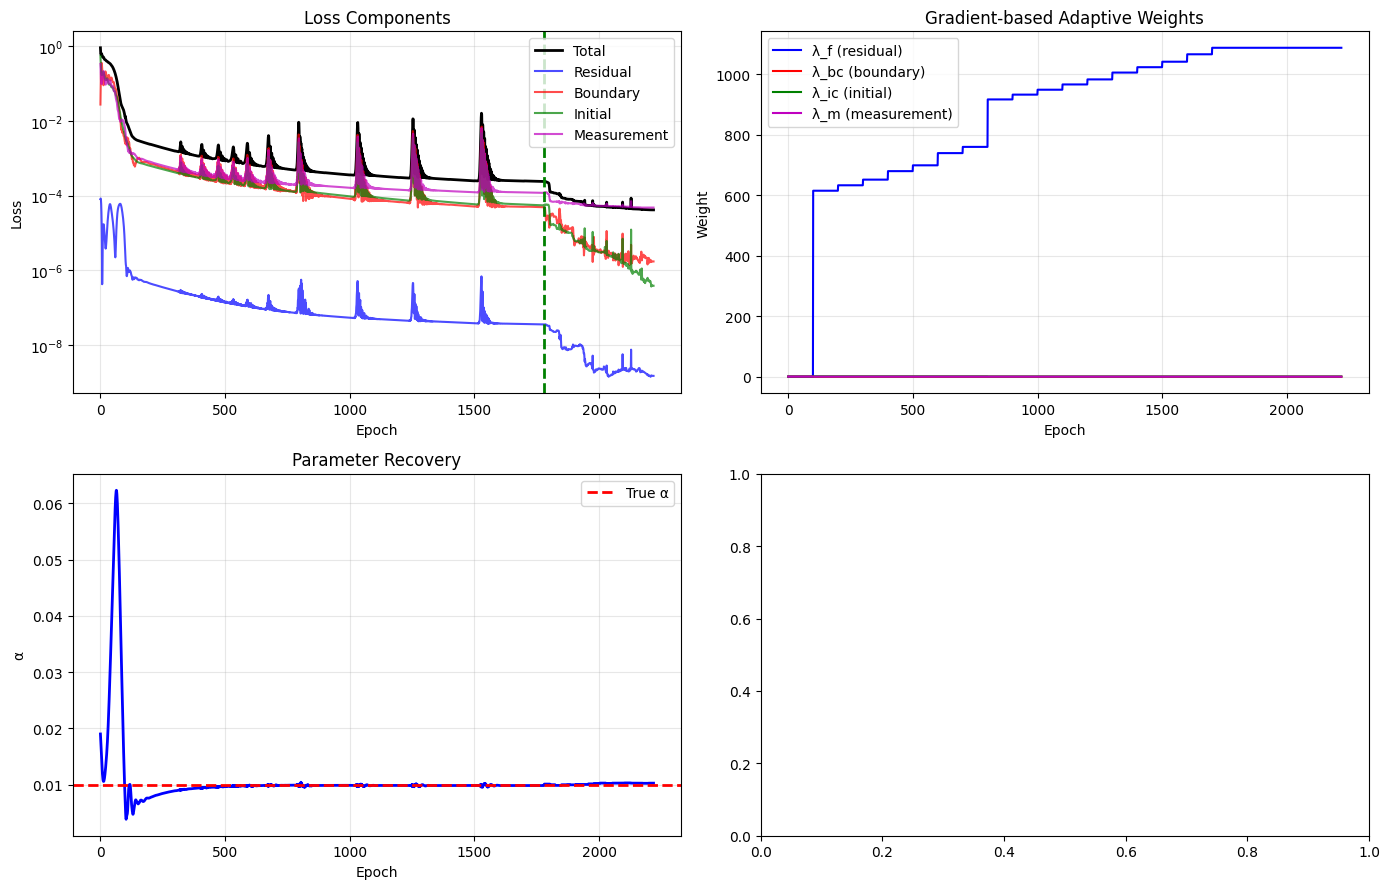


Training complete. Time: 427.1s


In [19]:
weak_model_inverse.set_loss_strategy(
    WeakFormLoss(
        integration_method='simpson',
        n_integration_points=21
    )
)

trainer_weak = StrategicPINNTrainer(
    model=weak_model_inverse, 
    data=weak_data,
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

trainer_weak.train(
    epochs=5000, 
    print_every=1000, 
    plot_every=2500)

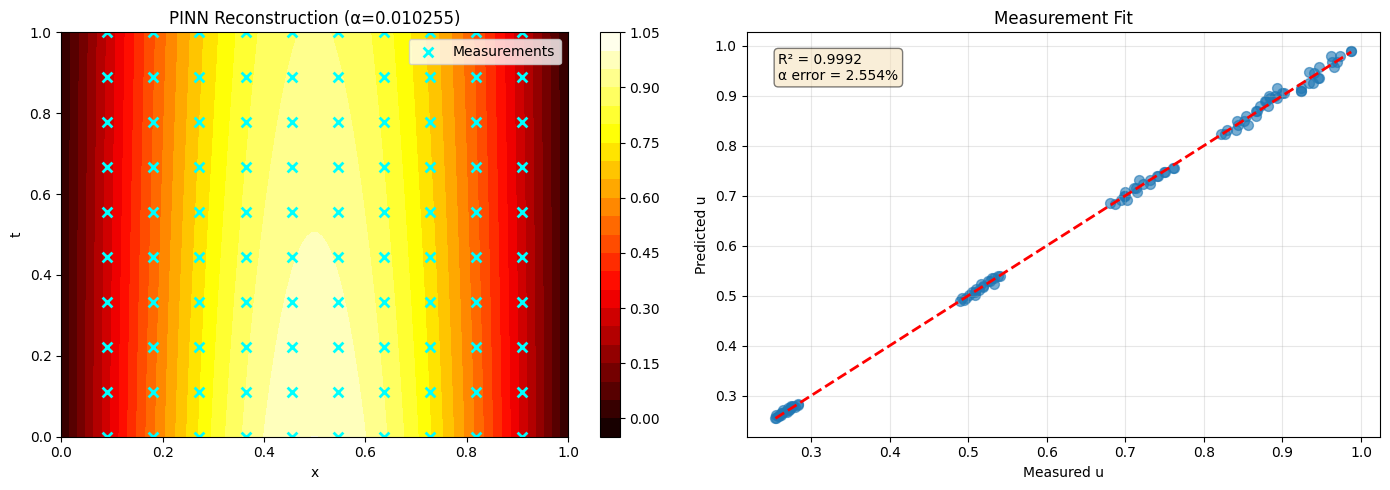

In [20]:
plot_solution(model=weak_model_inverse, data=weak_data, alpha_true=0.01)

### Gauss-Legendre integration

In [21]:
weak_model_inverse = StrategicPINN(
    layers=[2, 50, 50, 50, 50, 1], 
    inverse=True,
    alpha_init=0.02,
)

Inverse problem mode: alpha initialized to 0.02
StrategicPINN initialized with StrongFormLoss (default)


Weak-form loss strategy:
  Method: gauss_legendre
  Points: 15
Loss strategy changed to WeakFormLoss
Trainer initialized:
  Loss strategy: WeakFormLoss
  Adam LR: 0.001
  Switch criteria: var < 0.1, |slope| < 0.001
  L-BFGS max iter: 20
  Tracking gradient L2 norms: False
  Adaptive weights: True
  EMA smoothing: 0.9
  Update frequency: every 100 epochs
  Problem type: Inverse

Starting training...

Epoch 0/5000 (0.2s)
  Adam learning rate: 1.00e-03
  Total: 1.329186e+00
  Residual: 1.592492e-05 (λ=1.00)
  Boundary: 2.009224e-02 (λ=1.00)
  Initial: 6.131687e-01 (λ=1.00)
  Measurement: 6.959090e-01 (λ=1.00)
  Alpha: 0.019001 (true: 0.01)
  Non-zero weak residuals: 50

Epoch 1000/5000 (158.9s)
  Adam learning rate: 1.00e-03
  Total: 5.542436e-04
  Residual: 1.115048e-07 (λ=552.23)
  Boundary: 1.190749e-04 (λ=0.51)
  Initial: 1.691544e-04 (λ=1.18)
  Measurement: 2.776162e-04 (λ=0.83)
  Alpha: 0.009789 (true: 0.01)
  Non-zero weak residuals: 50

Epoch 2000/5000 (308.5s)
  Adam learning rat

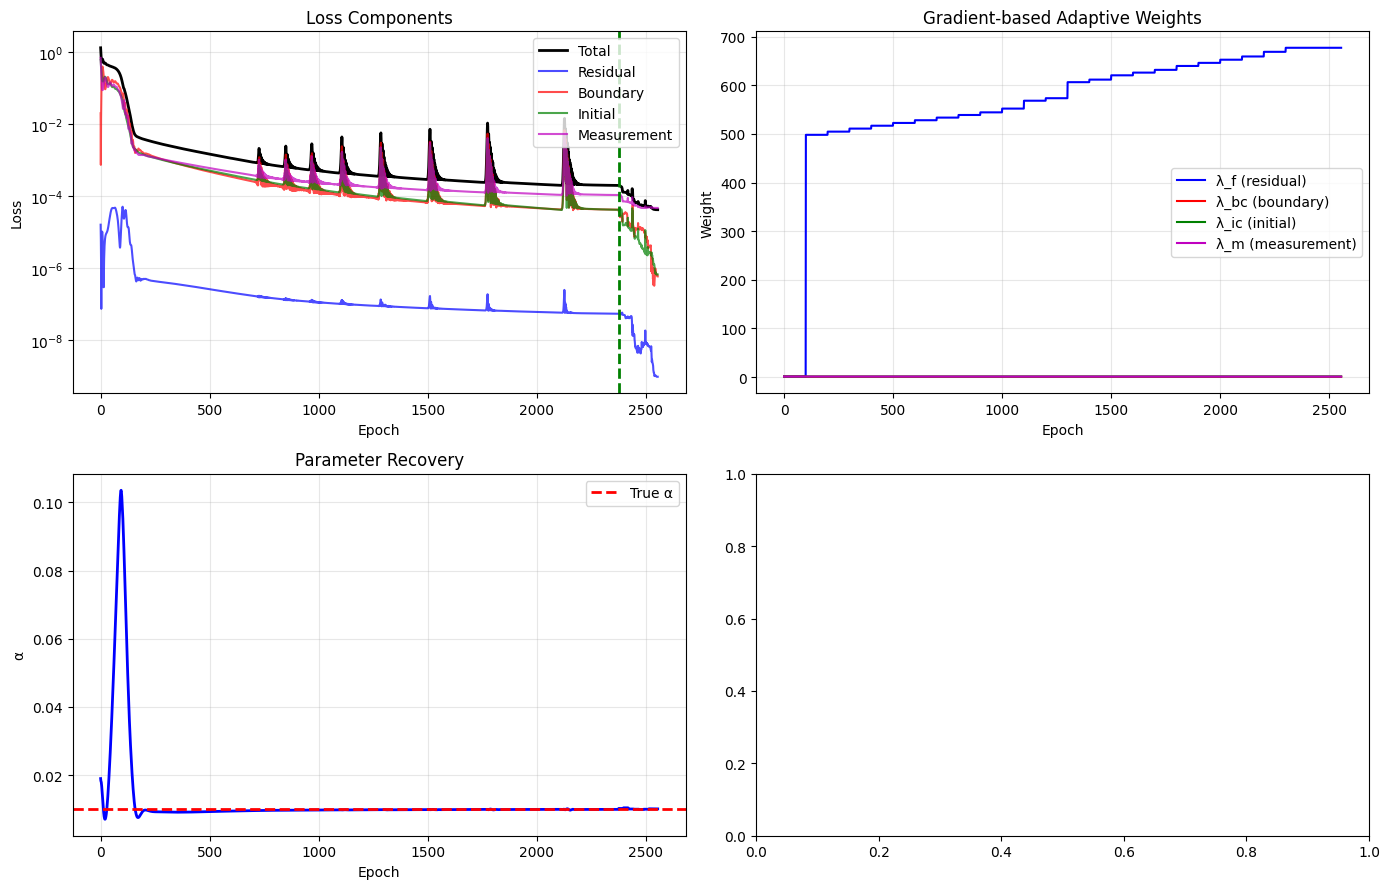


Training complete. Time: 396.5s


In [22]:
weak_model_inverse.set_loss_strategy(
    WeakFormLoss(
        integration_method='gauss_legendre',
        n_integration_points=15
    )
)

trainer_weak = StrategicPINNTrainer(
    model=weak_model_inverse, 
    data=weak_data,
    learning_rate=1e-3,
    switch_var=0.1,
    switch_slope=0.001,
    track_gradient_norms=False,
    adaptive_weights=True,
)

trainer_weak.train(
    epochs=5000, 
    print_every=1000, 
    plot_every=2500)

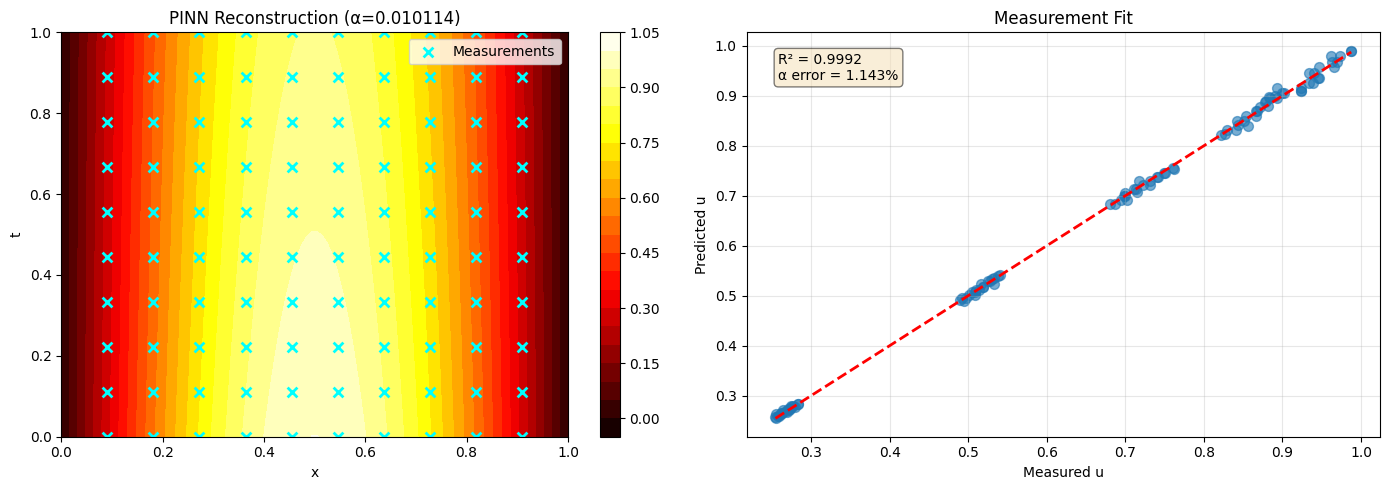

In [23]:
plot_solution(model=weak_model_inverse, data=weak_data, alpha_true=0.01)